# Simulación de Gestión de Inventario en una Tienda
[Ejemplo 7.6 del libro "Simulation, Fifth Edition by Sheldon M. Ross"]

### _*Situación:*_ 
Una tienda vende un producto a un precio fijo por unidad. Los clientes llegan según un proceso Poisson y demandan cantidades aleatorias. La tienda utiliza una política de inventario (s, S) para reponer stock cuando el nivel es bajo.

### _*Objetivos:*_

- Estimar el beneficio esperado hasta un tiempo T

- Evaluar políticas de inventario óptimas


### 1. Definir Parámetros y Distribuciones 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parámetros Fijos ---
params = {
    "lambda": 2,          # Tasa promedio de llegada de clientes (Poisson)
    "r": 10,              # Precio de venta por unidad ($)
    "h": 0.5,             # Costo de almacenamiento por unidad/tiempo ($)
    "L": 2,               # Tiempo de entrega (lead time)
    "s": 5,               # Punto de reorden (s)
    "S": 20,              # Nivel máximo de inventario (S)
    "T": 30,              # Tiempo total de simulación (horas/días)
    "c": lambda y: 5 * y  # Costo variable de ordenar y unidades ($5 por unidad)
}

# --- Distribución de Demanda (G) ---
# Decisión: Usar distribución geométrica con p=0.3 (justificación abajo)
params["demand_dist"] = lambda: np.random.geometric(p=0.3) + 1  # +1 para evitar demanda=0

Justificación de la distribución geométrica:

- Es común modelar demandas discretas con distribuciones como Poisson, binomial negativa o geométrica.

- Elegí la geométrica porque modela el número de intentos hasta el primer éxito, lo que podría representar clientes que compran hasta agotar un stock mínimo. El +1 asegura que la demanda mínima sea 1.

### 2. Función de Simulación (Eventos Discretos)

In [2]:
def run_simulation(params):
    # Inicialización del estado del sistema
    t = 0                  # Tiempo actual
    x = params["S"]        # Inventario inicial (lleno al máximo S)
    y = 0                  # Unidades pendientes de entrega
    C = 0                  # Costo total de órdenes
    H = 0                  # Costo total de almacenamiento
    R = 0                  # Ingresos totales por ventas
    
    # Programación de eventos iniciales
    t0 = t - np.log(np.random.uniform()) / params["lambda"]  # Próxima llegada de cliente
    t1 = np.inf            # No hay órdenes pendientes al inicio

    # Bucle principal de eventos
    while t < params["T"]:
        if t0 < t1:  # Evento: Llegada de cliente
            # Actualizar costos de almacenamiento hasta t0
            H += (t0 - t) * x * params["h"]
            t = t0  # Avanzar el tiempo
            
            # Generar demanda del cliente
            D = params["demand_dist"]()
            w = min(D, x)  # Unidades que se pueden vender
            
            # Actualizar inventario e ingresos
            R += w * params["r"]
            x -= w
            
            # Decidir si ordenar más (política s, S)
            if x < params["s"] and y == 0:
                y = params["S"] - x  # Cantidad a ordenar
                t1 = t + params["L"]  # Programar entrega
            
            # Programar próxima llegada de cliente
            t0 = t - np.log(np.random.uniform()) / params["lambda"]
            
        else:  # Evento: Entrega de orden
            # Actualizar costos de almacenamiento hasta t1
            H += (t1 - t) * x * params["h"]
            t = t1  # Avanzar el tiempo
            
            # Recibir la orden y actualizar costos
            C += params["c"](y)
            x += y
            y = 0
            t1 = np.inf  # No hay órdenes pendientes

    # Calcular ganancia promedio por unidad de tiempo
    avg_profit = (R - C - H) / params["T"]
    return {"avg_profit": avg_profit, "total_revenue": R, "total_cost": C + H}

- Inventario inicial: Se inicia en S para simular un sistema que comienza lleno.

- Programación de eventos: $t_0$ y $t_1$ se actualizan dinámicamente según los eventos (llegadas o entregas).

- Política (s, S): Solo se ordena si el inventario está por debajo de s y no hay órdenes pendientes.

### 3. Ejecutar Múltiples Réplicas

In [4]:
# Ejecutar 1000 réplicas para obtener una distribución estable
n_runs = 1000
results = [run_simulation(params) for _ in range(n_runs)]

# Convertir resultados a DataFrame para análisis
df = pd.DataFrame(results)
print(df.describe())

        avg_profit  total_revenue   total_cost
count  1000.000000    1000.000000  1000.000000
mean     22.821337    1439.860000   755.219902
std       3.177488     151.542554    71.992773
min      12.170830     950.000000   519.193072
25%      20.719382    1330.000000   710.514374
50%      22.993618    1450.000000   752.905758
75%      24.717048    1550.000000   808.148080
max      32.995144    1950.000000   965.092313


### 4. Generar gráficas descriptivas

Gráfico 1: Distribución de Ganancias Promedio (histograma de ganancias)

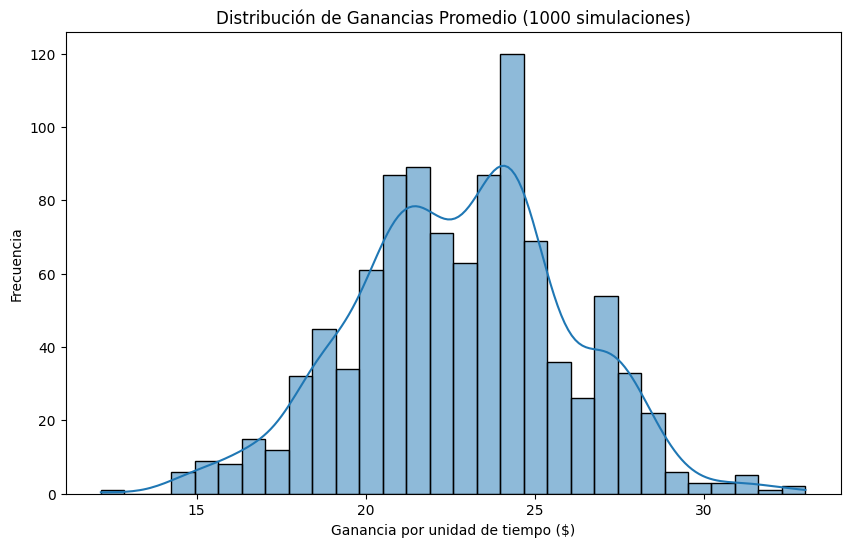

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df["avg_profit"], kde=True, bins=30)
plt.title("Distribución de Ganancias Promedio (1000 simulaciones)")
plt.xlabel("Ganancia por unidad de tiempo ($)")
plt.ylabel("Frecuencia")
plt.show()

Gráfico 2: Relación entre Ingresos y Costos (Scatterplot de ingresos vs costos)

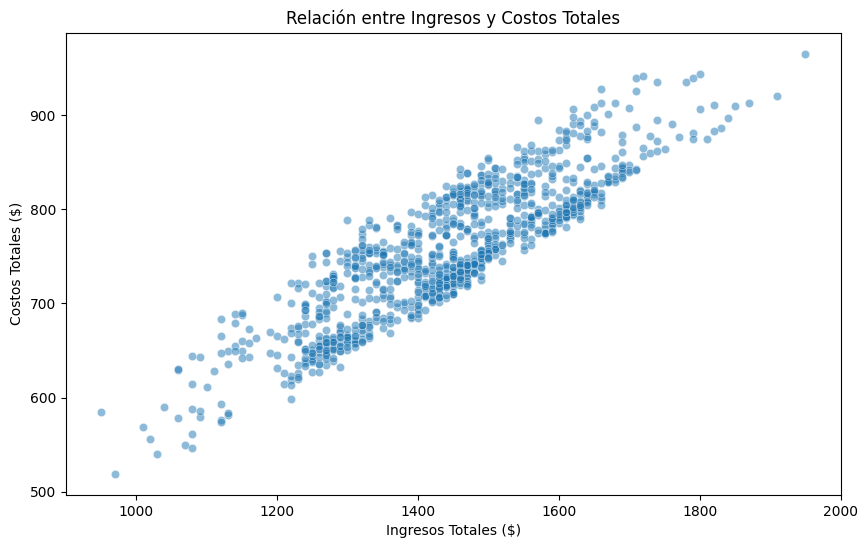

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="total_revenue", y="total_cost", alpha=0.5)
plt.title("Relación entre Ingresos y Costos Totales")
plt.xlabel("Ingresos Totales ($)")
plt.ylabel("Costos Totales ($)")
plt.show()

### 5. Experimentación con Diferentes Políticas (s, S)

Para comparar políticas, variamos s y S:

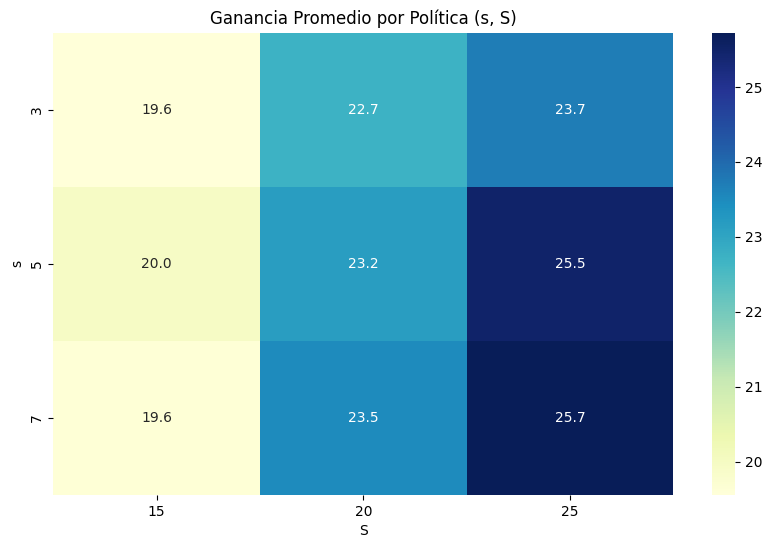

In [7]:
# Definir políticas a probar
s_values = [3, 5, 7]
S_values = [15, 20, 25]

# Ejecutar experimentos
experiment_results = []
for s in s_values:
    for S in S_values:
        params["s"], params["S"] = s, S
        # 100 réplicas por política para reducir ruido
        runs = [run_simulation(params) for _ in range(100)]
        avg_profit = np.mean([run["avg_profit"] for run in runs])
        experiment_results.append({"s": s, "S": S, "avg_profit": avg_profit})

# Crear heatmap
df_experiment = pd.DataFrame(experiment_results)
pivot_table = df_experiment.pivot(index="s", columns="S", values="avg_profit")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Ganancia Promedio por Política (s, S)")
plt.xlabel("S")
plt.ylabel("s")
plt.show()